<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/mars_challenge/mars_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mars Challenge**

The [MARS Challenge](https://blog.marsauto.com/introducing-the-mars-challenge-fc84c5afafbe) involves estimated the velocity of an ego camera mounted on a vehicel using only video (with train and test splits)

We will attempt the MARS challenge with a simple approach

1. Compute Camera Motion Compension transformation matrix
2. Use Transformation Matrix and true speed values to train a model that will regress the velocity


We will train multiple baseline models and compare their performances. However, we will avoid ensembling since we are interested in real time applications. Let's get started!

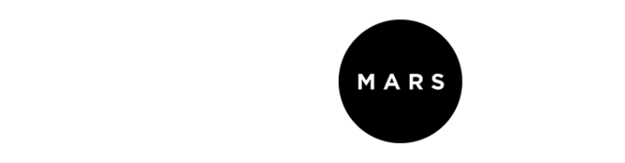

Download the data

In [ ]:
!wget https://marschallenge.s3.ap-northeast-2.amazonaws.com/train.mp4
!wget https://marschallenge.s3.ap-northeast-2.amazonaws.com/train.txt
!wget https://marschallenge.s3.ap-northeast-2.amazonaws.com/test.mp4

### **Import Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

### **Set up pipeline to collect transformation matrices for each frame pair**

In [6]:
def compute_motion_flow(frame1 : np.ndarray,
                        frame2 : np.ndarray,
                        method : int,
                        params : dict) -> np.ndarray:
    """
    Computes motion compensation transformation matrix (a rigid body transform)
    from frame 1 to frame 2
    Inputs:
      frame 1 - first grayscale frame
      frame 2 - second grayscale frame
      method - determines the method of feature detection
      params - parameters for feature detection
    Outputs:
      A - 2x3 Affine Transformation matrix that maps frame1 to frame2
      prev_points - key points in frame 1
      curr_points - matched key points in frame 2
    """

    # get corners of first image
    if method == 0:
        fast = cv2.FastFeatureDetector_create(**params)
        corners = cv2.KeyPoint_convert(fast.detect(frame1, None))
    elif method == 1:
        corners = cv2.goodFeaturesToTrack(frame1, **params)

    # get matching features on next image
    matched_corners, status, error = cv2.calcOpticalFlowPyrLK(frame1, frame2, corners, None)

    # get valid matched features
    status = status.reshape((-1))
    prev_points = corners.reshape((-1, 2))[status==1]
    curr_points = matched_corners.reshape((-1, 2))[status==1]

    # estimate transformation matrix from frame 1 to frame 2
    A, _ = cv2.estimateAffinePartial2D(prev_points, curr_points, method=cv2.RANSAC)

    return A, prev_points, curr_points


# second method with ORB and KNN matching
def compute_motion_matching(frame1 : np.ndarray,
                            frame2 : np.ndarray,
                            orb : cv2.ORB,
                            flann : cv2.FlannBasedMatcher) -> np.ndarray:
    """
        Computes motion compensation transformation matrix (a rigid body transform)
        from frame 1 to frame 2
        Inputs:
          frame 1 - first grayscale frame
          frame 2 - second grayscale frame
          method - determines the method of feature detection
          params - parameters for feature detection
        Outputs:
          A - 2x3 Affine Transformation matrix that maps frame1 to frame2
          prev_points - key points in frame 1
          curr_points - matched key points in frame 2
        """

    # use ORB to get features and descriptors on both frames
    # orb = cv2.ORB_create(nfeatures=10000)
    # find the keypoints with ORB
    kp1 = orb.detect(frame1, None)
    kp2 = orb.detect(frame2, None)
    # compute the descriptors with ORB
    kp1, des1 = orb.compute(frame1, kp1)
    kp2, des2 = orb.compute(frame2, kp2)

    # get matches
    # FLANN_INDEX_KDTREE = 1
    # index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    # search_params = dict(checks=50) # or pass empty dictionary
    # flann = cv2.FlannBasedMatcher(index_params,search_params)

    # descriptors must be float32
    matches = flann.knnMatch(des1.astype(np.float32), des2.astype(np.float32), k=2)

    # get affine matrix
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)


    prev_points = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    curr_points = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    A, _ = cv2.estimateAffinePartial2D(prev_points, curr_points, method=cv2.RANSAC)

    return A, prev_points, curr_points

### **Speed Test**

In [22]:
cap = cv2.VideoCapture("train.mp4")

if (cap.isOpened() == False):
    print("Error opening video file")

frames = []
i = 0
while(cap.isOpened()):

    # read each video frame
    ret, frame = cap.read()

    if ret == True:
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

        # increment counter
        i += 1

        if (i > 1200):
            break

    # Break if nothing is returned
    else:
        break

# clean up
cap.release()
cv2.destroyAllWindows()
del cap

In [24]:
gray1 = frames[1000]
gray2 = frames[1001]

Set Parameters

In [54]:
# FAST (larger threshold --> fewer features )
params_0 = {'threshold' : 10}

# Shi-Thomasi
params_1 = {'maxCorners' : 10000,
            'qualityLevel' : 0.01,
            'minDistance' : 10}


In [55]:
# Initiate ORB detector
orb = cv2.ORB_create(nfeatures=5000)

# initiate FLANN matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50) # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

In [56]:
%timeit A0, prev_points_0, curr_points_0 = compute_motion_flow(gray1, gray2, method=0, params=params_0)

103 ms ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [57]:
%timeit A1, prev_points_1, curr_points_1 = compute_motion_flow(gray1, gray2, method=1, params=params_1)

29.8 ms ± 902 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [58]:
%timeit A2, prev_points_2, curr_points_2 = compute_motion_matching(gray1, gray2, orb, flann)

212 ms ± 29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
A0, prev_points_0, curr_points_0 = compute_motion_flow(gray1, gray2, method=0, params=params_0)
A1, prev_points_1, curr_points_1 = compute_motion_flow(gray1, gray2, method=1, params=params_1)
A2, prev_points_2, curr_points_2 = compute_motion_matching(gray1, gray2, orb, flann)

In [60]:
len(prev_points_0), len(prev_points_1), len(prev_points_2)

(5208, 812, 1499)

#### **Stream video and get training features**

In [62]:
cap = cv2.VideoCapture("train.mp4")

if (cap.isOpened() == False):
    print("Error opening video file")

X = []
prev_frame = None
i = 0
while(cap.isOpened()):

    # read each video frame
    ret, frame = cap.read()

    if ret == True:
        if i > 0:
          gray1 = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
          gray2 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
          A, _, _ = compute_motion_flow(gray1, gray2, method=1, params=params_1)

          # update features (transpose allows for separation of rot and trans)
          X.append(A.T.flatten())

        # update previous frame
        prev_frame = frame.copy()

        # increment counter
        i += 1

    # Break if nothing is returned
    else:
        break

# clean up
cap.release()
cv2.destroyAllWindows()
del cap

#### **Get Test Features**

In [63]:
cap = cv2.VideoCapture("test.mp4")

if (cap.isOpened() == False):
    print("Error opening video file")

X_test = []
prev_frame = None
i = 0
while(cap.isOpened()):

    # read each video frame
    ret, frame = cap.read()

    if ret == True:
        if i > 0:
          gray1 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
          gray2 = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
          A_test, _, _ = compute_motion_flow(gray1, gray2, method=1, params=params_1)

          # update features (transpose allows for separation of rot and trans)
          X_test.append(A_test.T.flatten())

        # update previous frame
        prev_frame = frame.copy()

        # increment counter
        i += 1

    # Break if nothing is returned
    else:
        break

# clean up
cap.release()
cv2.destroyAllWindows()
del cap

Store feature array in .txt file

In [ ]:
# place in array and account for first frame
X = np.vstack((np.zeros(6), np.array(X)))
X_test = np.vstack((np.zeros(6), np.array(X_test)))
print(X.shape, X_test.shape)

np.savetxt('train_X.txt', X)
np.savetxt('test_X.txt', X_test)

# convert back to 2x3 Transformation Matrix
# X[-1, :].reshape((3,2)).T

Load training data if necessary

In [6]:
# load training data
X = np.loadtxt('train_X.txt')
y = np.loadtxt('train.txt')
# y = np.loadtxt('train_y.txt')


# neglect first training sample
y = y[1:]
X = X[1:, :]

print(X.shape, y.shape)

(8099, 6) (8099,)


The training data that we have just aquired consists of the Camera Motion Compensation transformation for speed at each time stamp (except the first).

## **Break into train, valid, test splits**


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=0)

In [8]:
X_train.shape, X_valid.shape, X_test.shape

((6479, 6), (810, 6), (810, 6))

## **Study the Collected Features**

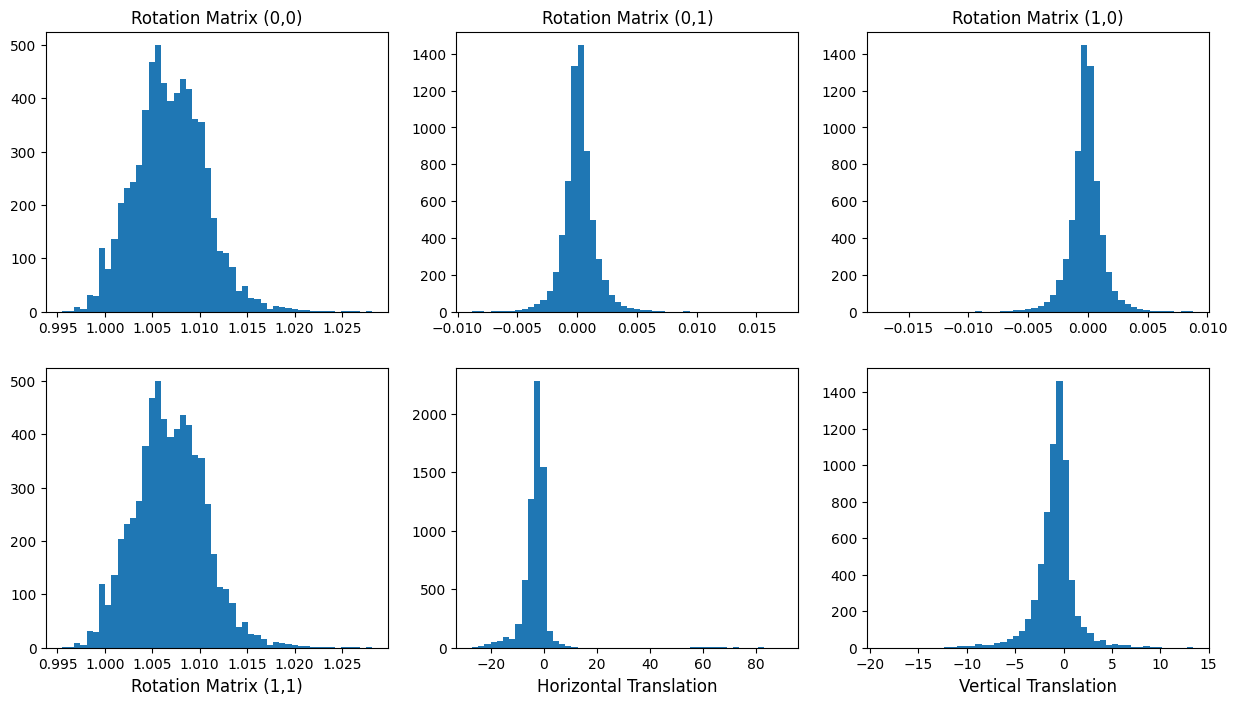

In [71]:
_, ax = plt.subplots(2, 3, figsize=(15, 8))
ax[0, 0].hist(X_train[:, 0], bins=50)
ax[0, 0].set_title("Rotation Matrix (0,0)", size=12)
ax[0, 1].hist(X_train[:, 1], bins=50)
ax[0, 1].set_title("Rotation Matrix (0,1)", size=12)
ax[0, 2].hist(X_train[:, 2], bins=50)
ax[0, 2].set_title("Rotation Matrix (1,0)", size=12)
ax[1, 0].hist(X_train[:, 3], bins=50)
ax[1, 0].set_xlabel("Rotation Matrix (1,1)", size=12)
ax[1, 1].hist(X_train[:, 4], bins=50)
ax[1, 1].set_xlabel("Horizontal Translation", size=12)
ax[1, 2].hist(X_train[:, 5], bins=50)
ax[1,2].set_xlabel("Vertical Translation", size=12);


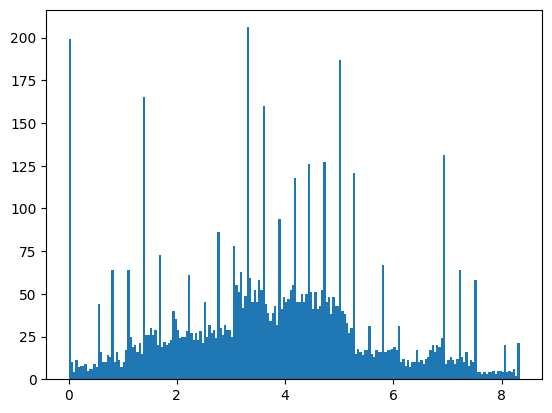

In [73]:
plt.hist(y_train, bins=200);

We will operate under the assumption that large outliers are due to large object motion and not camera motion. We further assume that true camera motion is very small and incremental.

## **Augment Train split**

We will make the assumption that when there is no translation or rotation, we will have a speed of 0. So we may want to consider adding some augmented samples that have an identity rotation matrix with a 0 translation vector that corresponds to a 0 speed.

<br>

**NOTE: It seems like the acquired motion compensations are not ideal even when the vehicle speed is zero. Adding this augmentation could really mess things up, since it could change the distriubtion of the acquired data! The code to generate the augmented data is inclued, but we will not add this augmnentation in this notebook**

In [10]:
n_aug = 500

x_aug = np.zeros((2, 3))
x_aug[0, 0] = 1.0
x_aug[1, 1] = 1.0

X_aug = np.repeat(np.c_[x_aug.T.flatten()], 100, axis=1).T
y_aug = np.zeros((n_aug,))

In [11]:
X_aug.shape, y_aug.shape

((100, 6), (500,))

In [12]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train.reshape((-1, 1)))

In [13]:
# test scaler
x_scaler.transform(X_train).mean(axis=0), x_scaler.transform(X_train).std(axis=0)

(array([-7.90521633e-14, -3.97347261e-16,  3.97347261e-16, -7.90521633e-14,
        -1.66594285e-15,  3.46422056e-16]),
 array([1., 1., 1., 1., 1., 1.]))

In [14]:
# test inverse scaler
X_train.mean(axis=0), X_train.std(axis=0)

(array([ 1.00685856e+00,  1.67779185e-04, -1.67779185e-04,  1.00685856e+00,
        -3.23530577e+00, -8.36619497e-01]),
 array([3.70724763e-03, 1.40981812e-03, 1.40981812e-03, 3.70724763e-03,
        6.12261239e+00, 2.07808680e+00]))

In [15]:
x_scaler.inverse_transform(x_scaler.transform(X_train)).mean(axis=0), x_scaler.inverse_transform(x_scaler.transform(X_train)).std(axis=0)

(array([ 1.00685856e+00,  1.67779185e-04, -1.67779185e-04,  1.00685856e+00,
        -3.23530577e+00, -8.36619497e-01]),
 array([3.70724763e-03, 1.40981812e-03, 1.40981812e-03, 3.70724763e-03,
        6.12261239e+00, 2.07808680e+00]))

# **Build Baseline Models**

For this tutorial we will build a few baseline models
- Linear Model
- Neural Network
- Support Vector Machine
- Random Forest
- XGBoost

In [16]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn import svm


# enet = ElasticNet(alpha=0.1, l1_ratio=0.05, random_state=0)
lreg = LinearRegression()
svr = svm.SVR()
xgb_rf = xgb.XGBRFRegressor(random_state=0)
xgbr = xgb.XGBRegressor(random_state=0)

Build neural network

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6, 10)
        self.fc2 = nn.Linear(10, 4)
        self.fc3 = nn.Linear(4, 1)

    def forward(self, x):
        # x1 = F.relu(self.fc1(x))
        # x2 = F.relu(self.fc2(x1))
        # x3 = F.relu(self.fc3(x2 + x1))

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return x


net = Net()
print(net)

# test pass
# net(torch.rand(32, 6))

Net(
  (fc1): Linear(in_features=6, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)


### **Train models**

In [18]:
# scale data
X_train_s = x_scaler.transform(X_train)
y_train_s = y_scaler.transform(y_train.reshape((-1, 1)))
X_valid_s = x_scaler.transform(X_valid)
y_valid_s = y_scaler.transform(y_valid.reshape((-1, 1)))


lreg.fit(X_train_s, y_train_s)
print("Linear Regression fit complete")

svr.fit(X_train_s, y_train_s.ravel())
print("Support Vector Machine Regressor fit complete")

xgb_rf.fit(X_train_s, y_train_s)
print("Random Forest fit complete")

xgbr.fit(X_train_s, y_train_s)
print("XGBoost fit complete")

Linear Regression fit complete
Support Vector Machine Regressor fit complete
Random Forest fit complete
XGBoost fit complete


Get train RMSE

In [19]:
from sklearn.metrics import mean_squared_error

# Linear Regression
y_train_lreg_preds = lreg.predict(X_train_s)

lreg_train_rmse = mean_squared_error(y_train_s, y_train_lreg_preds)
print(f"Linear Regression train RMSE: {lreg_train_rmse}")

# Support Vector Regressor
y_train_svr_preds = svr.predict(X_train_s)

svr_train_rmse = mean_squared_error(y_train_s, y_train_svr_preds)
print(f"SVR train RMSE: {svr_train_rmse}")

# Random Forest
y_train_rf_preds = xgb_rf.predict(X_train_s)

rf_train_rmse = mean_squared_error(y_train_s, y_train_rf_preds)
print(f"Random Forest train RMSE: {rf_train_rmse}")

# XG Boost
y_train_xgb_preds = xgbr.predict(X_train_s)

xgb_train_rmse = mean_squared_error(y_train_s, y_train_xgb_preds)
print(f"XG Boost train RMSE: {xgb_train_rmse}")

Linear Regression train RMSE: 0.7708830759400708
SVR train RMSE: 0.5246301727037485
Random Forest train RMSE: 0.42657714236996414
XG Boost train RMSE: 0.15295598518837636


Train Neural Network

In [84]:
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x,y

    def __len__(self):
        return len(self.data)


train_dataset = CustomDataset(x_scaler.transform(X_train),
                              y_scaler.transform(y_train.reshape((-1, 1))))
valid_dataset = CustomDataset(x_scaler.transform(X_valid),
                              y_scaler.transform(y_valid.reshape((-1, 1))))

trainloader = DataLoader(train_dataset, batch_size=32)
validloader = DataLoader(valid_dataset, batch_size=32)

In [85]:
import torch.optim as optim

criterion = nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.005)
optimizer = optim.Adam(net.parameters(), lr=0.03)

In [86]:
train_loss = []
valid_loss = []
for e in range(100):

    # train loop
    train_losses = []
    for x,y in trainloader:
        # cast to float32
        x, y = x.to(torch.float), y.to(torch.float)

        y_pred = net(x)
        loss = torch.sqrt(criterion(y, y_pred))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.detach().numpy())

    # update loss
    train_loss.append(np.sum(train_losses)/len(trainloader))


    # validation loop
    valid_losses = []
    with torch.no_grad():
        for x,y in validloader:
            # cast to float32
            x, y = x.to(torch.float), y.to(torch.float)

            y_pred = net(x)
            loss = torch.sqrt(criterion(y, y_pred))

            valid_losses.append(loss.detach().numpy())

        valid_loss.append(np.sum(valid_losses)/len(validloader))

    # print progress
    print(f"Epoch: {e+1} - train loss: {train_loss[-1]} - valid loss: {valid_loss[-1]}")

Epoch: 1 - train loss: 0.9473965649534328 - valid loss: 0.9595711781428411
Epoch: 2 - train loss: 0.9365219341710284 - valid loss: 0.9563405697162335
Epoch: 3 - train loss: 0.9145392807833667 - valid loss: 0.9297329829289362
Epoch: 4 - train loss: 0.8988942113415949 - valid loss: 0.928920158973107
Epoch: 5 - train loss: 0.8992339636891934 - valid loss: 0.9177055358886719
Epoch: 6 - train loss: 0.8967551245477986 - valid loss: 0.9155078301062951
Epoch: 7 - train loss: 0.8958627484702124 - valid loss: 0.9147599293635442
Epoch: 8 - train loss: 0.8953858925203971 - valid loss: 0.9117073645958533
Epoch: 9 - train loss: 0.8946267113897014 - valid loss: 0.9112079326923077
Epoch: 10 - train loss: 0.8941136252116687 - valid loss: 0.9114052699162409
Epoch: 11 - train loss: 0.8936396255868996 - valid loss: 0.9126412318303034
Epoch: 12 - train loss: 0.8913060080241687 - valid loss: 0.908017085148738
Epoch: 13 - train loss: 0.8917413720943658 - valid loss: 0.9103197684654822
Epoch: 14 - train loss:

## **Validate Models**

In [20]:
# Linear Regression
y_valid_lreg_preds = lreg.predict(X_valid_s)

lreg_valid_rmse = mean_squared_error(y_valid_s, y_valid_lreg_preds)
print(f"Linear Regression validation RMSE: {lreg_valid_rmse}")

# Support Vector Regressor
y_valid_svr_preds = svr.predict(X_valid_s)

svr_valid_rmse = mean_squared_error(y_valid_s, y_valid_svr_preds)
print(f"SVR validation RMSE: {svr_valid_rmse}")

# Random Forest
y_valid_rf_preds = xgb_rf.predict(X_valid_s)

rf_valid_rmse = mean_squared_error(y_valid_s, y_valid_rf_preds)
print(f"Random Forest validation RMSE: {rf_valid_rmse}")

# XG Boost
y_valid_xgb_preds = xgbr.predict(X_valid_s)

xgb_valid_rmse = mean_squared_error(y_valid_s, y_valid_xgb_preds)
print(f"XG Boost validation RMSE: {xgb_valid_rmse}")

Linear Regression validation RMSE: 0.8151066135331163
SVR validation RMSE: 0.5799675194212748
Random Forest validation RMSE: 0.4758497434999192
XG Boost validation RMSE: 0.4387424639367192


## **Focus on Random Forest and XG Boost**

Tune these parameters

In [21]:
xgb_rf = xgb.XGBRFRegressor(
    n_estimators=100,
    max_depth=5,
    # max_leaves=0,
    # learning_rate=0.8,
    reg_alpha=0.01,
    # reg_lambda=0.1,
    # gamma=0,
    random_state=0
    )
xgbr = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    # random_state=0,
    # max_leaves=0,
    # learning_rate=0.8,
    # reg_alpha=0.01,
    # reg_lambda=0.1,
    # gamma=0,
    random_state=0
    )

In [22]:
xgb_rf.fit(X_train_s, y_train_s)
print("Random Forest fit complete")

xgbr.fit(X_train_s, y_train_s)
print("XGBoost fit complete")

Random Forest fit complete
XGBoost fit complete


In [23]:
# Random Forest
y_train_rf_preds = xgb_rf.predict(X_train_s)
y_valid_rf_preds = xgb_rf.predict(X_valid_s)

rf_train_rmse = mean_squared_error(y_train_s, y_train_rf_preds)
rf_valid_rmse = mean_squared_error(y_valid_s, y_valid_rf_preds)
print(f"Random Forest - train RMSE: {rf_train_rmse:.4f} - validation RMSE: {rf_valid_rmse:.4f}")

# XG Boost
y_train_xgb_preds = xgbr.predict(X_train_s)
y_valid_xgb_preds = xgbr.predict(X_valid_s)

xgb_train_rmse = mean_squared_error(y_train_s, y_train_xgb_preds)
xgb_valid_rmse = mean_squared_error(y_valid_s, y_valid_xgb_preds)
print(f"XG Boost - train RMSE: {xgb_train_rmse:.4f}  - validation RMSE: {xgb_valid_rmse:.4f}")

Random Forest - train RMSE: 0.4605 - validation RMSE: 0.5073
XG Boost - train RMSE: 0.2170  - validation RMSE: 0.4418


Best performance:
  - Random Forest validation RMSE: 0.4645639643722361
  - XG Boost validation RMSE: 0.42891753740490174

# **Retrain with all the data**

In [24]:
X.shape, y.shape

((8099, 6), (8099,))

In [25]:
xgbr = xgb.XGBRegressor(random_state=0)

# scale data
scaler_x = StandardScaler().fit(X)
scaler_y = StandardScaler().fit(y.reshape((-1, 1)))

Xs = scaler_x.transform(X)
ys = scaler_y.transform(y.reshape((-1, 1)))

xgbr.fit(Xs, ys)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

Get train RMSE

In [26]:
# XG Boost
y_train_preds = xgbr.predict(Xs)
train_rmse = mean_squared_error(ys, y_train_preds)

print(f"XG Boost - train RMSE: {train_rmse:.4f}")

XG Boost - train RMSE: 0.1715


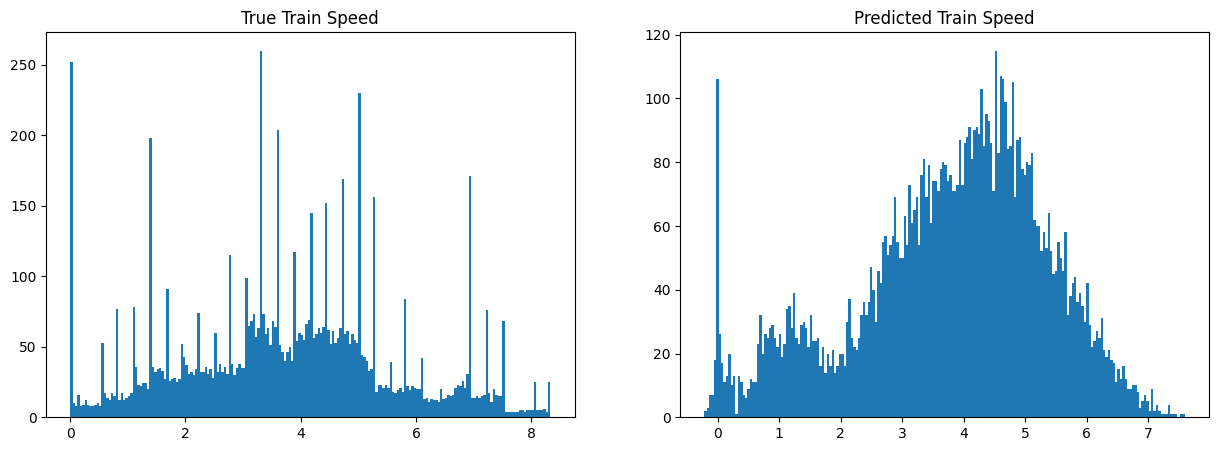

In [27]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(y, bins=200);
ax[0].set_title("True Train Speed")
ax[1].hist(scaler_y.inverse_transform(y_train_preds.reshape((-1,1))), bins=200)
ax[1].set_title("Predicted Train Speed");

#### **Inference on Test Data**

In [28]:
X_test = np.loadtxt('test_X.txt')
print(X_test.shape)

X_test_s = scaler_x.transform(X_test)

(6173, 6)


In [29]:
y_preds = xgbr.predict(X_test_s)

Text(0, 0.5, 'Counts')

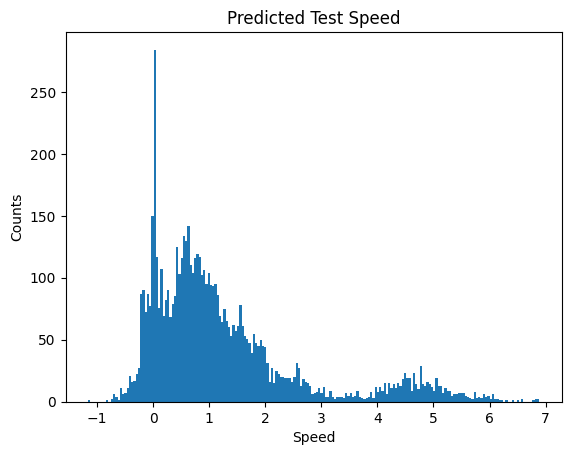

In [30]:
plt.hist(scaler_y.inverse_transform(y_preds.reshape((-1,1))), bins=200)
plt.title("Predicted Test Speed")
plt.xlabel('Speed')
plt.ylabel("Counts")

# **Make a Video**

Make one for the training data and another for the test data

In [31]:
rescaled_y_train_preds = scaler_y.inverse_transform(y_train_preds.reshape((-1,1)))
rescaled_y_test_preds = scaler_y.inverse_transform(y_preds.reshape((-1,1)))

In [101]:
np.savetxt("train_y_preds.txt", rescaled_y_train_preds)
np.savetxt("test_y_preds.txt", rescaled_y_test_preds)

In [33]:
# font
font = cv2.FONT_HERSHEY_SIMPLEX

# org
org_true = (15, 30)
org_pred = (15, 65)

# fontScale
fontScale = 1

# Blue color in BGR
color_true = (5, 255, 5)
color_pred = (255, 255, 255)

# Line thickness of 2 px
thickness = 3

In [103]:
cap = cv2.VideoCapture("train.mp4")

if (cap.isOpened() == False):
    print("Error opening video file")

train_fps = cap.get(cv2.CAP_PROP_FPS)
frames = []
i = 0
while(cap.isOpened()):

    # read each video frame
    ret, frame = cap.read()

    if ret == True:
        # get train truth and prediction
        if i == 0:
          y_true = y[i]
          y_pred = rescaled_y_train_preds[i][0]
        else:
          y_true = y[i-1]
          y_pred = rescaled_y_train_preds[i-1][0]

        # draw speeds on frame
        frame = cv2.putText(frame, f"True Speed: {y_true:.3f}", org_true, font,
                    fontScale, (0,0,0), 15, cv2.LINE_AA)
        frame = cv2.putText(frame, f"True Speed: {y_true:.3f}", org_true, font,
                            fontScale, color_true, thickness, cv2.LINE_AA)

        frame = cv2.putText(frame, f"Pred Speed: {y_pred:.3f}", org_pred, font,
                            fontScale, (0,0,0), 15, cv2.LINE_AA)
        frame = cv2.putText(frame, f"Pred Speed: {y_pred:.3f}", org_pred, font,
                            fontScale, color_pred, thickness, cv2.LINE_AA)

        # save to list
        frames.append(frame)

        # increment counter
        i += 1

    # Break if nothing is returned
    else:
        break

# clean up
cap.release()
cv2.destroyAllWindows()
del cap

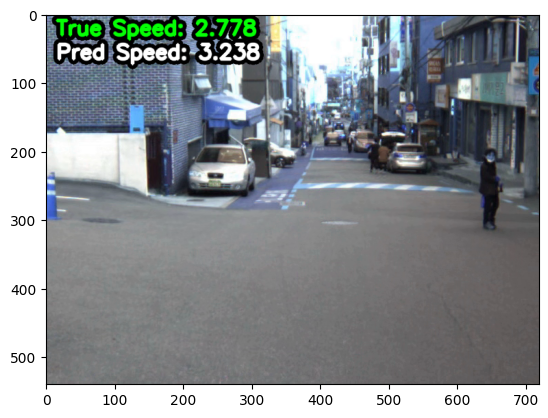

In [105]:
plt.imshow(frames[-1])

In [106]:
# save to mp4
w, h = frames[-1].shape[:2][::-1]
out = cv2.VideoWriter('train_output.mp4',
                      cv2.VideoWriter_fourcc(*'MP4V'),
                      train_fps,
                      (w, h))

for frame in frames:
    out.write(frame)
out.release()
del out

In [34]:
cap = cv2.VideoCapture("test.mp4")

if (cap.isOpened() == False):
    print("Error opening video file")

test_fps = cap.get(cv2.CAP_PROP_FPS)
test_frames = []
i = 0
while(cap.isOpened()):

    # read each video frame
    ret, frame = cap.read()

    if ret == True:
        # get test prediction
        if i == 0:
          y_pred = rescaled_y_test_preds[i][0]
        else:
          y_pred = rescaled_y_test_preds[i-1][0]

        # draw speed on frame
        frame = cv2.putText(frame, f"Pred Speed: {y_pred:.3f}", org_pred, font,
                            fontScale, (0,0,0), 15, cv2.LINE_AA)
        frame = cv2.putText(frame, f"Pred Speed: {y_pred:.3f}", org_pred, font,
                            fontScale, color_pred, thickness, cv2.LINE_AA)

        # save to list
        test_frames.append(frame)

        # increment counter
        i += 1

    # Break if nothing is returned
    else:
        break

# clean up
cap.release()
cv2.destroyAllWindows()
del cap

#### **Save Videos**

In [35]:
# save to mp4
w, h = test_frames[-1].shape[:2][::-1]
out = cv2.VideoWriter('test_output.mp4',
                      cv2.VideoWriter_fourcc(*'MP4V'),
                      test_fps,
                      (w, h))

for frame in test_frames:
    out.write(frame)
out.release()
del out